# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Incidents

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=True, processed=True, enhanced=True)

Loading dataset: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


In [5]:
df = data_loader.enhanced_incidents_df

# Response Time Histograms

C:\Users\sindr\AppData\Local\Temp\ipykernel_9144\552698709.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset['total_response_time'], bw_adjust=0.5, label=f'Triage {triage_category}, Urban {urban}', fill=True)


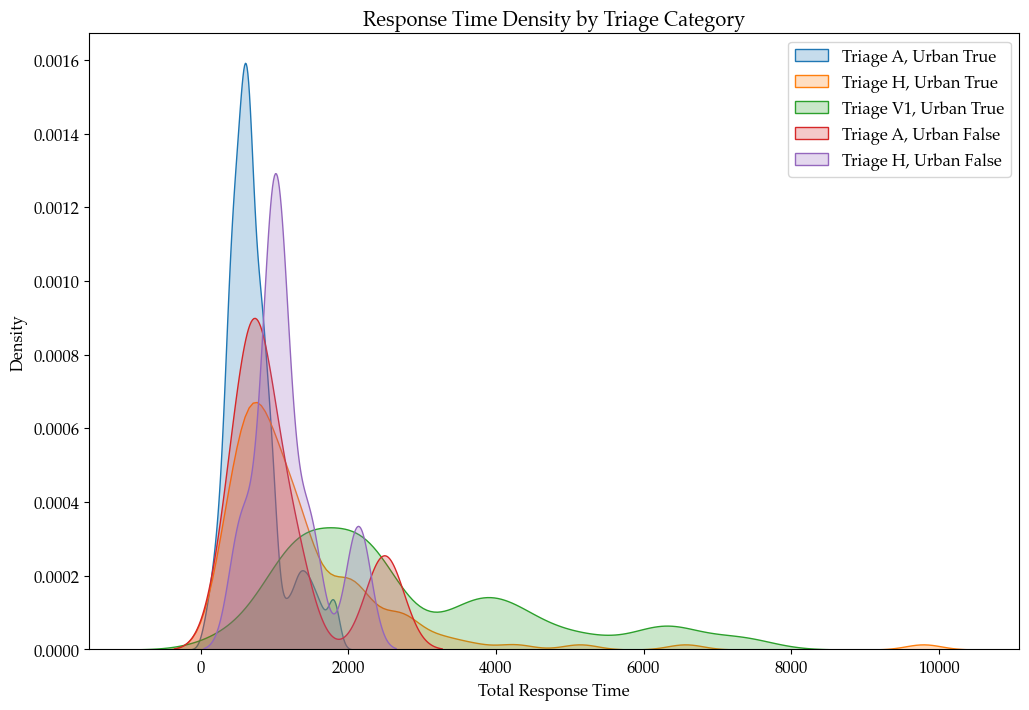

In [15]:
data = pd.read_csv('./metrics/metrics_2024-04-09_13-34-27.csv')

# Step 2: Preprocess the Data
data['time_call_received'] = pd.to_datetime(data['time_call_received'])
response_time_cols = ['duration_incident_creation', 'duration_resource_appointment',
                      'duration_resource_preparing_departure', 'duration_dispatching_to_scene']
data['total_response_time'] = data[response_time_cols].sum(axis=1)

# Step 3: Plotting
plt.figure(figsize=(12, 8))

# Plot a density plot for each triage category
for urban in [True, False]:
    for triage_category in data['triage_impression_during_call'].unique():
        subset = data[(data['triage_impression_during_call'] == triage_category) & (data['urban'] == urban)]
        sns.kdeplot(subset['total_response_time'], bw_adjust=0.5, label=f'Triage {triage_category}, Urban {urban}', fill=True)

plt.title('Response Time Density by Triage Category')
plt.xlabel('Total Response Time')
plt.ylabel('Density')
plt.legend()
plt.show()

